In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel("PSP_Jan_Feb_2019.xlsx")


In [2]:
df.shape
df.info()
df.isnull().sum()
print(df.describe())
print(df.describe(include =['object']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB
         Unnamed: 0                           tmsp        amount  \
count  50410.000000                          50410  50410.000000   
mean   25204.500000  2019-01-29 16:28:52.923269120    202.395715   
min        0.000000            2019-01-01 00:01:11      6.000000   
25%    12602.250000  2019-01-14 12:00:36.249999872    133.000000   
50%

In [3]:

import plotly.express as px
import plotly.graph_objects as go
card = ["UK_Card","Simplecard","Moneycard","Goldcard"]
success = [3,1,5,10]
fail = [1,0.5,2,5]
fig = go.Figure(data=[
    go.Bar(name= "Successfull transaction fees", x= card , y= success),
    go.Bar(name="Failed Transaction fees", x= card, y= fail)
])
fig.update_layout(title = "Service Fees Analysis", xaxis_title ="PSP", yaxis_title="Fees in euros",
                  barmode = "group")
fig.show()

In [4]:
import matplotlib.pyplot as plt
df1 = pd.DataFrame({
    "PSP":["Moneycard","Moneycard","Goldcard","UK_Card","UK_Card","Simplecard","Simplecard","Simplecard"],
    "success":[1,0,1,1,0,1,1,0]
})
SR = df1.groupby("PSP")["success"].agg(["mean","count"])
SR.rename(columns={"mean": "Success rate", "count": "Total Transactions"}, inplace = True)
SR

,Success rate,Total Transactions
PSP,,
Goldcard,1.000000,1
Moneycard,0.500000,2
Simplecard,0.666667,3
UK_Card,0.500000,2


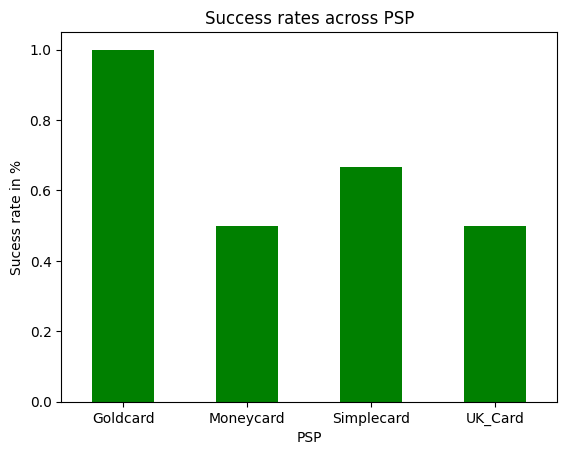

In [5]:
a,b = plt.subplots()
SR["Success rate"].plot(kind = "bar", color = "g", ax = b )
b.set_title("Success rates across PSP")
b.set_ylabel("Sucess rate in %")
plt.xticks(rotation = 0)
plt.show()

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Load the data
df = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

# Encode categorical features
encoder = LabelEncoder()
df["PSP"] = encoder.fit_transform(df["PSP"])
df["card"] = encoder.fit_transform(df["card"])
df["country"] = encoder.fit_transform(df["country"])

# Select features and target
attributes = df[["country", "card", "PSP", "amount", "3D_secured"]]
target = df["success"]

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(attributes, target, test_size=0.2, random_state=38)

# Standardize features
scaler = StandardScaler()
scale_xtrain = scaler.fit_transform(xtrain)
scale_xtest = scaler.fit_transform(xtest)

# Train Logistic Regression model
LR = LogisticRegression()
LR.fit(scale_xtrain, ytrain)

# Train XGBoost model
XGB = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
XGB.fit(scale_xtrain, ytrain)

# Make predictions with both models
LR_Forecast = LR.predict(scale_xtest)
XGB_Forecast = XGB.predict(scale_xtest)

# Evaluate Logistic Regression model
print("Accuracy of Logistic Regression:", accuracy_score(ytest, LR_Forecast))
print("Classification Report for Logistic Regression:\n", classification_report(ytest, LR_Forecast))

# Evaluate XGBoost model
print("Accuracy of XGBoost:", accuracy_score(ytest, XGB_Forecast))
print("Classification Report for XGBoost:\n", classification_report(ytest, XGB_Forecast))


Accuracy of Logistic Regression: 0.7942868478476492
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89      8008
           1       0.00      0.00      0.00      2074

    accuracy                           0.79     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.63      0.79      0.70     10082

Accuracy of XGBoost: 0.7617536203134299
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      8008
           1       0.29      0.11      0.16      2074

    accuracy                           0.76     10082
   macro avg       0.55      0.52      0.51     10082
weighted avg       0.70      0.76      0.72     10082



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_excel('PSP_Jan_Feb_2019.xlsx')
df['tmsp'] = pd.to_datetime(df['tmsp'])

df.sort_values(by='tmsp', inplace=True)
df['reattempt'] = df.duplicated(subset=['country', 'amount', 'card'], keep=False)
df['reattempt'] = df['reattempt'].astype(int)

# Encode categorical features (assuming you have done this previously in your data preparation)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["PSP"] = encoder.fit_transform(df["PSP"])
df["card"] = encoder.fit_transform(df["card"])
df["country"] = encoder.fit_transform(df["country"])

# Select features and target
attributes = df[["country", "card", "PSP", "amount", "3D_secured", "reattempt"]]
target = df["success"]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(attributes, target, test_size=0.2, random_state=38)

# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scale_xtrain = scaler.fit_transform(xtrain)
scale_xtest = scaler.fit_transform(xtest)

# Set up the parameter grid for XGBoost
PG = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up the grid search
GS = GridSearchCV(estimator=xgb_model, param_grid= PG, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Perform the grid search
GS.fit(scale_xtrain, ytrain)

# Output the best parameters and best score
print("Best parameters found: ", GS.best_params_)
print("Best accuracy found: ", GS.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}
Best accuracy found:  0.8008828067390095


In [11]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

best_xgb = GS.best_estimator_
y_pred = best_xgb.predict(scale_xtest)

# Evaluate the model
accuracy = accuracy_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
f1 = f1_score(ytest, y_pred)

# Display results
print(f'Accuracy: {accuracy:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.776
Recall: 0.088
F1 Score: 0.139
Confusion Matrix:
[[7640  368]
 [1891  183]]
